## compute_sigma_pressure
* Compute potential density (referenced at local depth). Take the time average over one day.
* Compute pressure

Resulting routines are in eos.py and vars.py

In [1]:
%load_ext memory_profiler
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
from pathlib import Path
import xarray as xr
from xgcm import Grid
import gridop as gop

from xorca.lib import load_xorca_dataset
from sigmai import sigmai

In [2]:
from dask.distributed import Client, LocalCluster, wait
# Start a local cluster with 4 single-threaded (HDF is triggering errors
# if they are multi-threaded) workers which get only 1500 MiB of memory each.
cluster = LocalCluster(n_workers=4, threads_per_worker=1, memory_limit=1500e6,
                       silence_logs=50)
client = Client(address=cluster)
client

Client Scheduler: tcp://127.0.0.1:50323 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 5.59 GiB


In [3]:
data_path = Path("/Users/nlahaye/tmp/eNATL60")

data_fname = "eNATL60NOE-BLBT02_y2010m01d01.1h_*_0-botm.nc"
ssh_fname = "eNATL60NOE-BLBT02_y2010m01.1h_ssh.nc"
grid_fname = ["mesh_*_eNATL60NOE_3.6.nc", "mask_eNATL60NOE_3.6.nc"]

data_files = list(data_path.glob(data_fname))
grid_files = sum([list(data_path.glob(fna)) for fna in grid_fname],[]) # trick to flatten: sum([list_of_list],[])

In [4]:
ds_tot = load_xorca_dataset(data_files=data_files, aux_files=grid_files,
                              decode_cf=True, model_config="nest"
                             )
print("dataset is {:.1f} GB".format(ds_tot.nbytes/1e9))
ds_tot

dataset is 2.6 GB


<xarray.Dataset>
Dimensions:   (t: 24, x_c: 121, x_r: 121, y_c: 139, y_r: 139, z_c: 300, z_l: 300)
Coordinates: (12/33)
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 ... 132 133 134 135 136 137 138 139
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 ... 136.5 137.5 138.5 139.5
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 ... 114 115 116 117 118 119 120 121
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 5.5 ... 118.5 119.5 120.5 121.5
    ...        ...
    e2f       (y_r, x_r) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e3w       (z_l, y_c, x_c) float64 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    tmask     (z_c, y_c, x_c) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    umask     (z_c, y_c, x_r) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    vmask     (z_c, y_r, x_c) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    fmask     (z_c, y_r, x_r) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
Data variables:
    vomecrty  (t, z_c, y_r, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    vosaline  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    votemper  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    vovecrtz  (t, z_l, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    vozocrtx  (t, z_c, y_c, x_r) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>

## Density
potential density (referenced at local depth here)

In [5]:
ds_tot["sigmai"] = sigmai(ds_tot)#.astype(ds_tot.votemper.dtype)
ds_tot

<xarray.Dataset>
Dimensions:   (t: 24, x_c: 121, x_r: 121, y_c: 139, y_r: 139, z_c: 300, z_l: 300)
Coordinates: (12/33)
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 ... 132 133 134 135 136 137 138 139
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 ... 136.5 137.5 138.5 139.5
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 ... 114 115 116 117 118 119 120 121
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 5.5 ... 118.5 119.5 120.5 121.5
    ...        ...
    e2f       (y_r, x_r) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e3w       (z_l, y_c, x_c) float64 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    tmask     (z_c, y_c, x_c) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    umask     (z_c, y_c, x_r) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    vmask     (z_c, y_r, x_c) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    fmask     (z_c, y_r, x_r) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
Data variables:
    vomecrty  (t, z_c, y_r, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    vosaline  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    votemper  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    vovecrtz  (t, z_l, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    vozocrtx  (t, z_c, y_c, x_r) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    sigmai    (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>

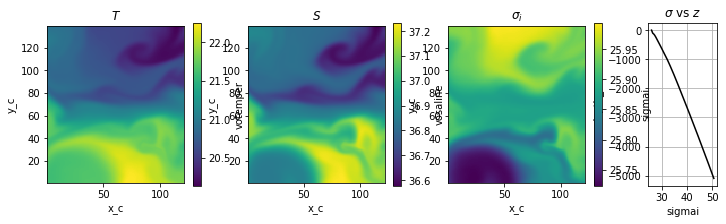

In [6]:
### plot fields at surface, and mean vertical profile of sigmai
fig, axs = plt.subplots(1, 4, figsize=(12,3), gridspec_kw={"width_ratios":[1, 1, 1, .4]})
ax = axs[0]
ds_tot.votemper.mean("t").isel(z_c=0).plot(ax=ax)
ax.set_title(r'$T$')
ax = axs[1]
ds_tot.vosaline.mean("t").isel(z_c=0).plot(ax=ax)
ax.set_title(r'$S$')
ax = axs[2]
ds_tot.sigmai.mean("t").isel(z_c=0).plot(ax=ax)
ax.set_title(r'$\sigma_i$')

ax = axs[3]
ds_tot.sigmai.where(ds_tot.tmask).mean(dim=("t", "x_c", "y_c")).plot(y="depth_c", color="k", ax=ax)
ax.set_title(r'$\sigma$ vs $z$')
ax.grid(True)

for ax in axs.ravel()[:-1]:
    ax.set_aspect(1)

## Pressure

In [7]:
### add ssh
ds_ssh = xr.open_dataset(data_path/ssh_fname)\
            .get("sossheig")\
            .rename({"x":"x_c", "y":"y_c", "time_counter":"t"})\
            .drop("time_centered")\
            .sel(t=ds_tot.t)
ds_tot = ds_tot.merge(ds_ssh)

In [9]:
metrics = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
    ('Z',): ['e3t', 'e3u', 'e3v', 'e3w'], # Z distances
    #('X', 'Y'): [] # Areas TODO
}


In [10]:
sds = ds_tot.get(["sossheig", "sigmai"]).isel(x_c=0, y_c=0).assign_coords(e3w=ds_tot.e3w).persist()
grid = Grid(sds, metrics={("Z",):["e3t","e3w"]}, periodic=False)
sds

<xarray.Dataset>
Dimensions:   (t: 24, x_c: 121, y_c: 139, z_c: 300, z_l: 300)
Coordinates: (12/14)
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 ... 114 115 116 117 118 119 120 121
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 ... 132 133 134 135 136 137 138 139
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
    depth_c   (z_c) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    llat_cc   (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    llon_cc   (y_c, x_c) float32 dask.array<chunksize=(139, 121), meta=np.ndarray>
    ...        ...
    e2t       (y_c, x_c) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e3t       (z_c) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    tmask     (z_c) int8 dask.array<chunksize=(2,), meta=np.ndarray>
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
    depth_l   (z_l) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    e3w       (z_l, y_c, x_c) float64 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
Data variables:
    sossheig  (t) float32 ...
    sigmai    (t, z_c) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>

In [17]:
_pres_dico = dict(ssh=None, var_dens="sigmai", zmet=None, on_t_pts=True, s_dens_ano=False, red_pres=True)

def comp_pres(ds, xgrid, **kwargs):
    """ compute pressure anomaly by vertical integration of local potential density 
    Pressure is computing by vertically integrating density: psurf + int_z \rho dz', 
    with \rho=sigma_i (potential density - 1000)
    
    Parameters
    __________
    ds: xarray Dataset
        dataset containing density - 1000. (for vertical integration)
        May also contain the ssh field and the grid interval
    xgrid: xgcm.Grid
        grid associated with ds. metrics will be used for vertical integration (unless delz is passed)
    ssh: str or xarray DataArray or bool, optional
        name of ssh field in ds dataset, or xr.DataArray containing ssh, or None (automatic) of False (use 0)
    var_dens: str, optional (default: "sigmai")
        name of density field in ds dataset (assume it is rho-1000)
    zmet: str or xarray DataArray, optional (default: None)
        name of grid spacing array in ds dataset, or xr.DataArray containing grid spacing, or None (use xgrid metrics)
    on_t_pts: bool, optional (default: True)
        wether pressure field must be re-interpolated on density grid or not
    s_dens_ano: bool, optional (default: False)
        wether full density (rho0 + anomaly) is used for computing the surface pressure anomaly (at z=0) or not. False is NEMO default
        
    Returns
    _______
    xarray.DataArray containing pressure anomaly
    
    TODO
    ____
     - update such that ds can be a DataArray only. 
     - verify wether sigmai or (sigmai - 26.0) should be used
    """
    rho0 = 1026. # pp_rau0 in CDFtools TODO have this from simulation output files
    sig0 = rho0-1000.   # rho0 - p_rau0
    grav = 9.81  # TODO use common default with e.g. xorca
    dico = _pres_dico.copy()
    dico.update(kwargs)
    s_dens_ano = int(dico["s_dens_ano"]) # 1 or 0: use density anomaly for surface pressure
    
    
    ### define ssh anomaly
    if dico["ssh"] is None:
        ssh = "sossheig"
    if not ssh:
        ssh = 0.
    elif isinstance(ssh, str):
        ssh = ds[ssh]
        
    dens = ds[dico["var_dens"]] - sig0 # now dens is dens-rho0

    ### compute pressure at surface (z=0)
    psurf = ssh * (s_dens_ano*dens + rho0)
    
    ### vertical integration of density
    zmet = dico["zmet"]
    if zmet is None: # this will use grid metrics in xgrid
        res = xgrid.cumint(dens, "Z", boundary="fill", fill_value=0.)
    else:
        if isinstance(zmet, str):
            zmet = ds[zmet]
        res = xgrid.cumsum(dens*zmet, "Z", boundary="fill", fill_value=0.)
        
    ### re-interpolate on t-points
    if dico["on_t_pts"]:
        res = xgrid.interp(res, "Z", boundary="extrapolate")
        
    # return pressure: multiply by gravity
    if dico["red_pres"]:
        grav /= rho0
    return grav * (res + psurf)


In [18]:
pres = comp_pres(sds, grid).persist()
pres = pres.assign_coords(depth_c=sds.depth_c)

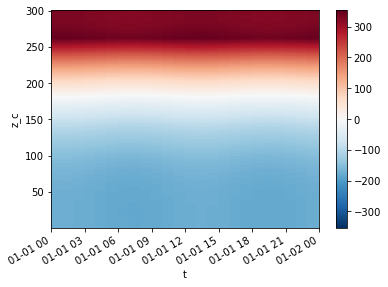

In [19]:
(pres-pres.mean(dim=("t","z_c"))).plot(y="z_c")

In [20]:
ds_tot

<xarray.Dataset>
Dimensions:   (t: 24, x_c: 121, x_r: 121, y_c: 139, y_r: 139, z_c: 300, z_l: 300)
Coordinates: (12/33)
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 ... 114 115 116 117 118 119 120 121
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 ... 132 133 134 135 136 137 138 139
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 ... 136.5 137.5 138.5 139.5
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 5.5 ... 118.5 119.5 120.5 121.5
    ...        ...
    e2f       (y_r, x_r) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e3w       (z_l, y_c, x_c) float64 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    tmask     (z_c, y_c, x_c) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    umask     (z_c, y_c, x_r) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    vmask     (z_c, y_r, x_c) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
    fmask     (z_c, y_r, x_r) int8 dask.array<chunksize=(2, 139, 121), meta=np.ndarray>
Data variables:
    vomecrty  (t, z_c, y_r, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    vosaline  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    votemper  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    vovecrtz  (t, z_l, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    vozocrtx  (t, z_c, y_c, x_r) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    sigmai    (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 139, 121), meta=np.ndarray>
    sossheig  (t, y_c, x_c) float32 ...